In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.timeseries import LombScargle
from astropy.io import fits
from scipy import stats
from sklearn.utils import check_random_state
import time as tm

import numpy as np


from scipy.fftpack import fft, ifft, fftshift



In [2]:

def FT_continuous(t, h, axis=-1, method=1):
    """Approximate a continuous 1D Fourier Transform with sampled data.

    This function uses the Fast Fourier Transform to approximate
    the continuous fourier transform of a sampled function, using
    the convention

    .. math::

       H(f) = \int h(t) exp(-2 \pi i f t) dt

    It returns f and H, which approximate H(f).

    Parameters
    ----------
    t : array_like
        regularly sampled array of times
        t is assumed to be regularly spaced, i.e.
        t = t0 + Dt * np.arange(N)
    h : array_like
        real or complex signal at each time
    axis : int
        axis along which to perform fourier transform.
        This axis must be the same length as t.

    Returns
    -------
    f : ndarray
        frequencies of result.  Units are the same as 1/t
    H : ndarray
        Fourier coefficients at each frequency.
    """
    assert t.ndim == 1
    assert h.shape[axis] == t.shape[0]
    N = len(t)
    if N % 2 != 0:
        raise ValueError("number of samples must be even")

    Dt = t[1] - t[0]
    Df = 1. / (N * Dt)
    t0 = t[N // 2]

    f = Df * (np.arange(N) - N // 2)

    shape = np.ones(h.ndim, dtype=int)
    shape[axis] = N

    phase = np.ones(N)
    phase[1::2] = -1
    phase = phase.reshape(shape)

    if method == 1:
        H = Dt * fft(h * phase, axis=axis)
    else:
        H = Dt * fftshift(fft(h, axis=axis), axes=axis)

    H *= phase
    H *= np.exp(-2j * np.pi * t0 * f.reshape(shape))
    H *= np.exp(-1j * np.pi * N / 2)

    return f, H



def PSD_continuous(t, h, axis=-1, method=1):
    """Approximate a continuous 1D Power Spectral Density of sampled data.

    This function uses the Fast Fourier Transform to approximate
    the continuous fourier transform of a sampled function, using
    the convention

    .. math::

        H(f) = \int h(t) \exp(-2 \pi i f t) dt

    It returns f and PSD, which approximate PSD(f) where

    .. math::

        PSD(f) = |H(f)|^2 + |H(-f)|^2

    Parameters
    ----------
    t : array_like
        regularly sampled array of times
        t is assumed to be regularly spaced, i.e.
        t = t0 + Dt * np.arange(N)
    h : array_like
        real or complex signal at each time
    axis : int
        axis along which to perform fourier transform.
        This axis must be the same length as t.

    Returns
    -------
    f : ndarray
        frequencies of result.  Units are the same as 1/t
    PSD : ndarray
        Fourier coefficients at each frequency.
    """
    assert t.ndim == 1
    assert h.shape[axis] == t.shape[0]
    N = len(t)
    if N % 2 != 0:
        raise ValueError("number of samples must be even")

    ax = axis % h.ndim

    if method == 1:
        # use FT_continuous
        f, Hf = FT_continuous(t, h, axis)
        Hf = np.rollaxis(Hf, ax)
        f = -f[N // 2::-1]
        PSD = abs(Hf[N // 2::-1]) ** 2
        PSD[:-1] += abs(Hf[N // 2:]) ** 2
        PSD = np.rollaxis(PSD, 0, ax + 1)
    else:
        # A faster way to do it is with fftshift
        # take advantage of the fact that phases go away
        Dt = t[1] - t[0]
        Df = 1. / (N * Dt)
        f = Df * np.arange(N // 2 + 1)
        Hf = fft(h, axis=axis)
        Hf = np.rollaxis(Hf, ax)
        PSD = abs(Hf[:N // 2 + 1]) ** 2
        PSD[-1] = 0
        PSD[1:] += abs(Hf[N // 2:][::-1]) ** 2
        PSD[0] *= 2
        PSD = Dt ** 2 * np.rollaxis(PSD, 0, ax + 1)

    return f, PSD





def generate_power_law(N, dt, beta, generate_complex=False,random_state=None):
    """Generate a power-law light curve
    This uses the method from Timmer & Koenig [1]_
    Parameters
    ----------
    N : integer
        Number of equal-spaced time steps to generate
    dt : float
        Spacing between time-steps
    beta : float
        Power-law index.  The spectrum will be (1 / f)^beta
    generate_complex : boolean (optional)
        if True, generate a complex time series rather than a real time series

    Returns
    -------
    x : ndarray
        the length-N
    References
    ----------
    .. [1] Timmer, J. & Koenig, M. On Generating Power Law Noise. A&A 300:707
    """
    random_state = check_random_state(random_state)
    dt = float(dt)
    N = int(N)

    Npos = int(N / 2)
    Nneg = int((N - 1) / 2)
    domega = (2 * np.pi / dt / N)

    if generate_complex:
        omega = domega * np.fft.ifftshift(np.arange(N) - int(N / 2))
    else:
        omega = domega * np.arange(Npos + 1)

    x_fft = np.zeros(len(omega), dtype=complex)
    x_fft.real[1:] = random_state.normal(0, 1, len(omega) - 1)
    x_fft.imag[1:] = random_state.normal(0, 1, len(omega) - 1)

    x_fft[1:] *= (1. / omega[1:]) ** (0.5 * beta)
    x_fft[1:] *= (1. / np.sqrt(2))

    # by symmetry, the Nyquist frequency is real if x is real
    if (not generate_complex) and (N % 2 == 0):
        x_fft.imag[-1] = 0

    if generate_complex:
        x = np.fft.ifft(x_fft)
    else:
        x = np.fft.irfft(x_fft, N)

    return x

In [3]:
cp ../../u9712005/*18.npy .

In [4]:
############
name = 'u18'
mjd = np.load('mjd'+name+'.npy')
mag = np.load('mag'+name+'.npy')
dmag = np.load('dmag'+name+'.npy')
obnames = np.load('obnames'+name+'.npy')
time = np.load('time'+name+'.npy')


In [5]:
dt = 10./60./24. # ten minutes in days
Nnumber = 30/dt # 21 days or 3 weeks
beta = 2. # red noise beta = 2

ts = dt * np.arange(Nnumber)


lcsimul = generate_power_law(Nnumber,dt,beta)


#Add Noise
noise =  np.random.normal(size=len(lcsimul),loc=np.mean(dmag),scale=np.std(dmag))
lcsimulnoise = lcsimul + noise


#Scale
lcsimulscalenoise = np.array([(i-lcsimulnoise.mean())/lcsimulnoise.std() for i in lcsimulnoise])
lcsimulscalenoise = lcsimulscalenoise*mag.std()+mag.mean()

f, PSD = PSD_continuous(ts, lcsimulscalenoise)

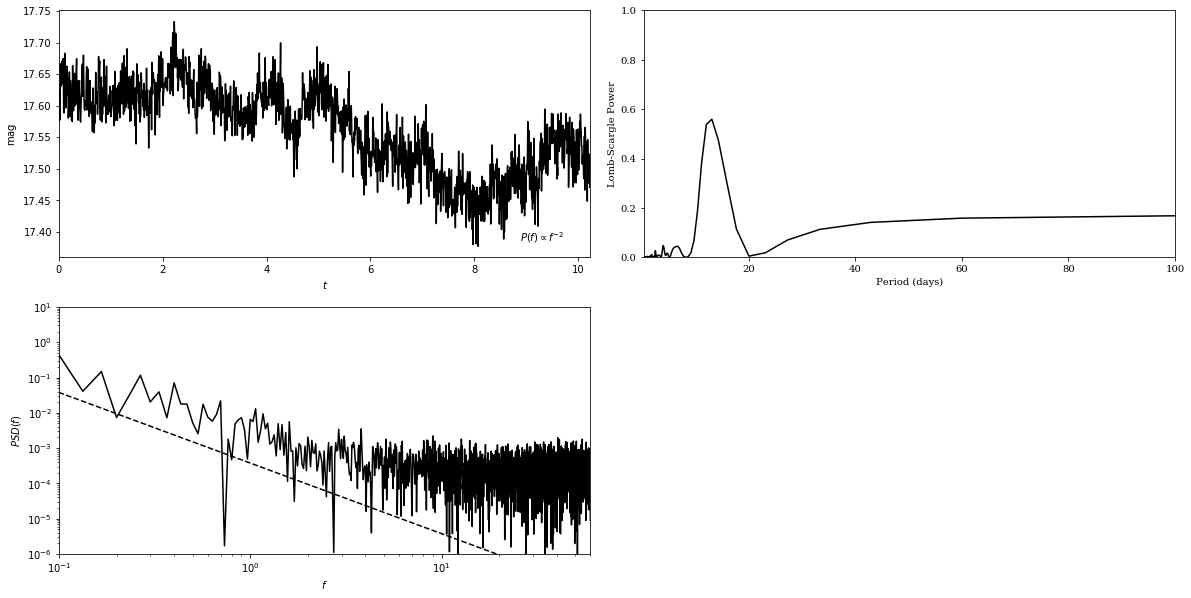

In [6]:
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(wspace=0.1,hspace=0.2)


# First axes: plot the time series
ax1 = fig.add_subplot(221)
ax1.plot(ts, lcsimulscalenoise, '-k')

ax1.text(0.95, 0.05, r"$P(f) \propto f^{-%i}$" % beta,
         ha='right', va='bottom', transform=ax1.transAxes)

ax1.set_xlim(0, 10.24)
#ax1.set_ylim(-1.5, 1.5)

ax1.set_xlabel(r'$t$')

# Second axes: plot the PSD
ax2 = fig.add_subplot(223 , xscale='log', yscale='log')
ax2.plot(f, PSD, '-k')
ax2.plot(f[1:], (lcsimulscalenoise.mean()*dt) ** 2 * (2 * np.pi * f[1:]) ** -beta, '--k')

ax2.set_xlim(1E-1, 60)
ax2.set_ylim(1E-6, 1E1)

ax2.set_xlabel(r'$f$')


ax1.set_ylabel(r'${\rm mag}$')
ax2.set_ylabel(r'$PSD(f)$')

#Lomb

freq, PLS = LombScargle(ts, lcsimulscalenoise, noise).autopower(minimum_frequency=1 / 100.,
                                                maximum_frequency=1 / 0.1)
best_freq = freq[np.argmax(PLS)]
phase = (mjd * best_freq) % 1

# compute the best-fit model
phase_fit = np.linspace(0, 1,len(mjd))
mag_fit = LombScargle(ts, lcsimulscalenoise, noise).model(t=phase_fit / best_freq,
                                          frequency=best_freq)
# plot the periodogram

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')


#fig = plt.figure(figsize=(10, 6))

ax3 = fig.add_subplot(222)
ax3.set(xlim=(0.2, 100),
          ylim=(0, 1));
ax3.set_xlabel('Period (days)',fontsize=10)
ax3.set_ylabel('Lomb-Scargle Power')
ax3.tick_params(axis='both', which='major', labelsize=10)


ax3.plot(1./freq, PLS,color='k',ls='solid')

#plt.show()
#save iamge
#riodogram.eps', format='eps',bbox_inches = "tight")

plt.show()

# Get data points close to observation

In [7]:
newmjd = ts + mjd.min()
mjdsort = np.sort(mjd)
magsort = mag[np.argsort(mjd)]

closestarg = np.array([np.abs(i-newmjd).argmin() for i in mjdsort])


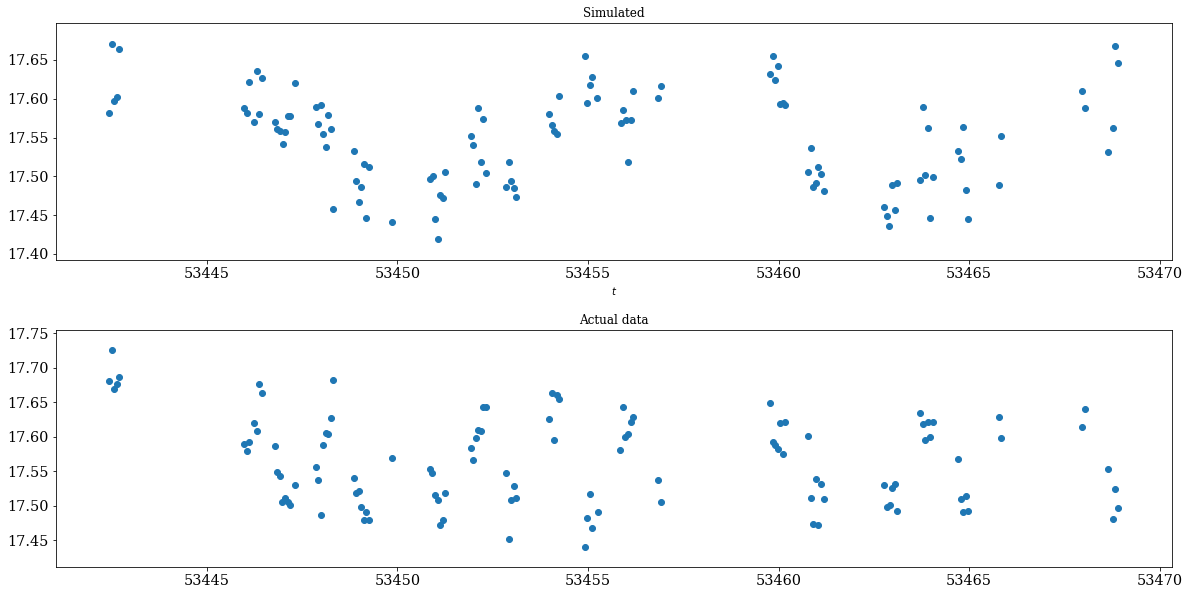

In [8]:
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(wspace=0.1,hspace=0.3)


# First axes: plot the time series
ax1 = fig.add_subplot(211)
ax1.title.set_text('Simulated')
ax1.scatter(newmjd[closestarg],lcsimulscalenoise[closestarg])


ax1.set_xlabel(r'$t$')

ax2 = fig.add_subplot(212,sharex=ax1)
ax2.title.set_text('Actual data')

ax2.scatter(mjdsort,magsort)



closest

0.7698648009572514


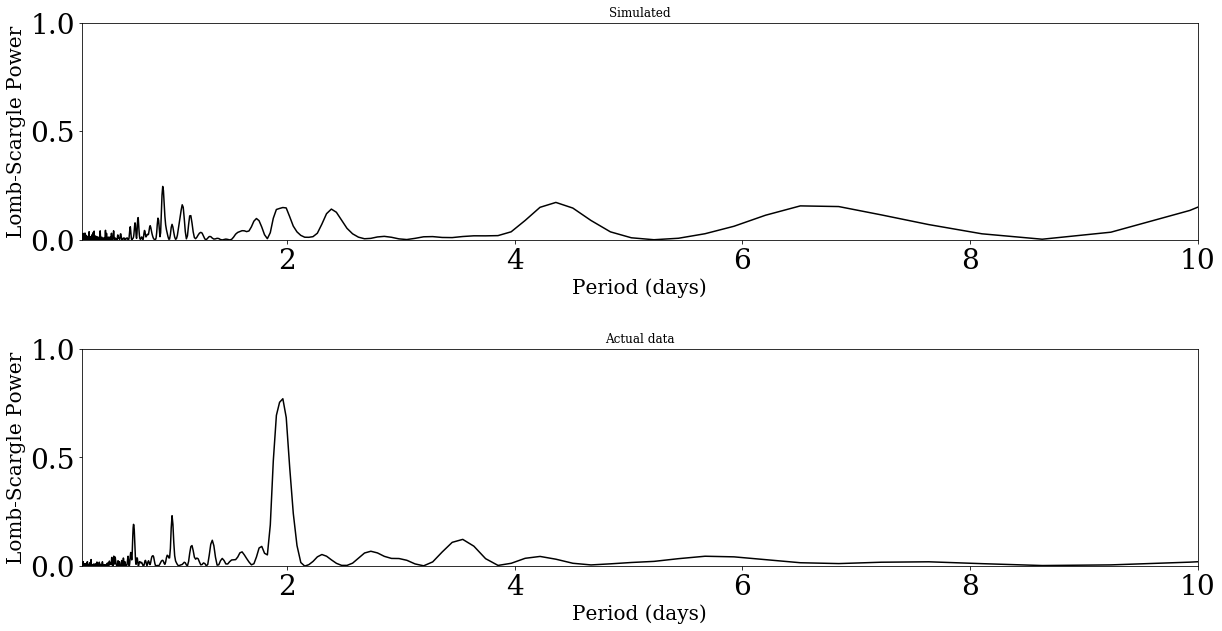

In [9]:

simulmjdclose = newmjd[closestarg]
lcsimulclose = lcsimulscalenoise[closestarg]
noiseclose = noise[closestarg]


freq, PLS = LombScargle(simulmjdclose, lcsimulclose, noiseclose).autopower(minimum_frequency=1 / 100.,
                                                maximum_frequency=1 / 0.1)
best_freq = freq[np.argmax(PLS)]
phase = (mjd * best_freq) % 1

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')

fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(wspace=0.1,hspace=0.5)

# First axes: plot the time series
ax1 = fig.add_subplot(211)
ax1.title.set_text('Simulated')
ax1.set(xlim=(0.2, 10),
          ylim=(0, 1));
ax1.set_xlabel('Period (days)',fontsize=20)
ax1.set_ylabel('Lomb-Scargle Power',fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=28)


ax1.plot(1./freq, PLS,color='k',ls='solid')

#save iamge
#fig.savefig('periodogram.eps', format='eps',bbox_inches = "tight")




freq, PLS = LombScargle(mjd, mag, dmag).autopower(minimum_frequency=1 / 100.,
                                                maximum_frequency=1 / 0.1)
best_freq = freq[np.argmax(PLS)]
phase = (mjd * best_freq) % 1


# plot the periodogram
print(np.max(PLS))
maxdata = np.max(PLS)


#plt.rc('font', family='serif')
#plt.rc('xtick', labelsize='x-large')
#plt.rc('ytick', labelsize='x-large')

ax2 = fig.add_subplot(212,sharex=ax1)
ax2.title.set_text('Actual data')
ax2.set(xlim=(0.2, 10),
          ylim=(0, 1));
ax2.set_xlabel('Period (days)',fontsize=20)
ax2.set_ylabel('Lomb-Scargle Power',fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=28)


ax2.plot(1./freq, PLS,color='k',ls='solid')




plt.show()


In [10]:
maxdata

0.7698648009572514

# Do it many times

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.timeseries import LombScargle
from astropy.io import fits
from scipy import stats
from sklearn.utils import check_random_state
import time as tm

import numpy as np


from scipy.fftpack import fft, ifft, fftshift

def find_nearest1(array,value):
    idx,val = min(enumerate(array), key=lambda x: abs(x[1]-value))
    return idx




def lcsim(timestodo):
    start = tm.time()
    dt = 10./60./24. # ten minutes in days
    Nnumber = 30/dt # 21 days or 3 weeks
    beta = 2. # red noise beta = 2

    maxvals = []
    bestfreqs = []
    plsmax = []
    plots = False
    for i in np.arange(timestodo):



        ts = dt * np.arange(Nnumber)


        lcsimul = generate_power_law(Nnumber,dt,beta)


        #Add Noise
        noise =  np.random.normal(size=len(lcsimul),loc=np.mean(dmag),scale=np.std(dmag))
        lcsimulnoise = lcsimul + noise


        #Scale
        #lcsimulscalenoise = np.array([(i-lcsimulnoise.mean())/lcsimulnoise.std() for i in lcsimulnoise])
        lcsimulscalenoise = stats.zscore(lcsimulnoise)
        lcsimulscalenoise = lcsimulscalenoise*mag.std()+mag.mean()

        f, PSD = PSD_continuous(ts, lcsimulscalenoise)


        #
        newmjd = ts + mjd.min()
        mjdsort = np.sort(mjd)
        magsort = mag[np.argsort(mjd)]

        closestarg = [np.abs(i-newmjd).argmin() for i in mjdsort]
        #closestarg = np.array([find_nearest1(newmjd,i) for i in mjdsort])
        #find_nearest1(array,value)

        simulmjdclose = newmjd[closestarg]
        lcsimulclose = lcsimulscalenoise[closestarg]
        noiseclose = noise[closestarg]


        freq, PLS = LombScargle(simulmjdclose, lcsimulclose, noiseclose).autopower(minimum_frequency=1 / 10.,
                                                        maximum_frequency=1 / 0.1,method='fast')
        best_freq = freq[np.argmax(PLS)]
        phase = (mjd * best_freq) % 1

        maxvals.append(PLS.max())
        bestfreqs.append(best_freq)
        if PLS.max() > maxdata:
            plsmax.append(PLS)
        if i % 1000 == 0:
            print(i)
            print("Taken", tm.time() - start, "seconds.")

        if plots:

            plt.rc('font', family='serif')
            plt.rc('xtick', labelsize='x-large')
            plt.rc('ytick', labelsize='x-large')

            fig = plt.figure(figsize=(20, 10))
            fig.subplots_adjust(wspace=0.1,hspace=0.5)

            # First axes: plot the time series
            ax1 = fig.add_subplot(211)
            ax1.title.set_text(f'Simulated Max P{PLS.max()} at {1/best_freq}')
            #ax1.set(xlim=(0.2, 10),
            #          ylim=(0, 1));
            ax1.set(ylim=(0,1));
            ax1.set_xlabel('Period (days)',fontsize=20)
            ax1.set_ylabel('Lomb-Scargle Power',fontsize=20)
            ax1.tick_params(axis='both', which='major', labelsize=28)


            ax1.plot(1./freq, PLS,color='k',ls='solid')

            #save iamge
            #fig.savefig('periodogram.eps', format='eps',bbox_inches = "tight")




            freq, PLS = LombScargle(mjd, mag, dmag).autopower(minimum_frequency=1 / 10.,
                                                            maximum_frequency=1 / 0.1)
            best_freq = freq[np.argmax(PLS)]
            phase = (mjd * best_freq) % 1


            # plot the periodogram



            plt.show()




In [18]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.timeseries import LombScargle
from astropy.io import fits
from scipy import stats
from sklearn.utils import check_random_state
import time as tm

import numpy as np


from scipy.fftpack import fft, ifft, fftshift

def find_nearest1(array,value):
    idx,val = min(enumerate(array), key=lambda x: abs(x[1]-value))
    return idx




def lcsim(timestodo):
    start = tm.time()
    dt = 10./60./24. # ten minutes in days
    Nnumber = 30/dt # 21 days or 3 weeks
    beta = 2. # red noise beta = 2

    maxvals = []
    bestfreqs = []
    plsmax = []
    plots = False
    for i in np.arange(timestodo):



        ts = dt * np.arange(Nnumber)


        lcsimul = generate_power_law(Nnumber,dt,beta)


        #Add Noise
        noise =  np.random.normal(size=len(lcsimul),loc=np.mean(dmag),scale=np.std(dmag))
        lcsimulnoise = lcsimul + noise


        #Scale
        #lcsimulscalenoise = np.array([(i-lcsimulnoise.mean())/lcsimulnoise.std() for i in lcsimulnoise])
        lcsimulscalenoise = stats.zscore(lcsimulnoise)
        lcsimulscalenoise = lcsimulscalenoise*mag.std()+mag.mean()

        f, PSD = PSD_continuous(ts, lcsimulscalenoise)


        #
        newmjd = ts + mjd.min()
        mjdsort = np.sort(mjd)
        magsort = mag[np.argsort(mjd)]

        closestarg = np.array([np.abs(i-newmjd).argmin() for i in mjdsort])
        #closestarg = np.array([find_nearest1(newmjd,i) for i in mjdsort])
        #find_nearest1(array,value)

        simulmjdclose = newmjd[closestarg]
        lcsimulclose = lcsimulscalenoise[closestarg]
        noiseclose = noise[closestarg]


        freq, PLS = LombScargle(simulmjdclose, lcsimulclose, noiseclose).autopower(minimum_frequency=1 / 10.,
                                                        maximum_frequency=1 / 0.1,method='fast')
        best_freq = freq[np.argmax(PLS)]
        phase = (mjd * best_freq) % 1

        maxvals.append(PLS.max())
        bestfreqs.append(best_freq)
        if PLS.max() > maxdata:
            plsmax.append(PLS)
        if i % 1000 == 0:
            print(i)
            print("Taken", tm.time() - start, "seconds.")

        if plots:

            plt.rc('font', family='serif')
            plt.rc('xtick', labelsize='x-large')
            plt.rc('ytick', labelsize='x-large')

            fig = plt.figure(figsize=(20, 10))
            fig.subplots_adjust(wspace=0.1,hspace=0.5)

            # First axes: plot the time series
            ax1 = fig.add_subplot(211)
            ax1.title.set_text(f'Simulated Max P{PLS.max()} at {1/best_freq}')
            #ax1.set(xlim=(0.2, 10),
            #          ylim=(0, 1));
            ax1.set(ylim=(0,1));
            ax1.set_xlabel('Period (days)',fontsize=20)
            ax1.set_ylabel('Lomb-Scargle Power',fontsize=20)
            ax1.tick_params(axis='both', which='major', labelsize=28)


            ax1.plot(1./freq, PLS,color='k',ls='solid')

            #save iamge
            #fig.savefig('periodogram.eps', format='eps',bbox_inches = "tight")




            freq, PLS = LombScargle(mjd, mag, dmag).autopower(minimum_frequency=1 / 10.,
                                                            maximum_frequency=1 / 0.1)
            best_freq = freq[np.argmax(PLS)]
            phase = (mjd * best_freq) % 1


            # plot the periodogram



            plt.show()




In [19]:
lcsim(1001)

0
Taken 0.032860517501831055 seconds.
1000
Taken 15.331719398498535 seconds.


In [12]:
%load_ext line_profiler

In [13]:
from vaina import lcsim2

In [16]:
%lprun -f lcsim2 lcsim2(1000)

0
Taken 0.04148602485656738 seconds.


Timer unit: 1e-06 s

Total time: 14.796 s
File: /home/mmarcano/Documents/BackUpNGC6397F336W/Notebooks/SimulateLC/vaina.py
Function: lcsim2 at line 214

Line #      Hits         Time  Per Hit   % Time  Line Contents
   214                                           def lcsim2(timestodo):
   215         1          7.0      7.0      0.0      start = tm.time()
   216         1          4.0      4.0      0.0      dt = 10./60./24. # ten minutes in days
   217         1          5.0      5.0      0.0      Nnumber = 30/dt # 21 days or 3 weeks
   218         1          3.0      3.0      0.0      beta = 2. # red noise beta = 2
   219                                           
   220         1          3.0      3.0      0.0      maxvals = []
   221         1          3.0      3.0      0.0      bestfreqs = []
   222         1          3.0      3.0      0.0      plsmax = []
   223         1          3.0      3.0      0.0      plots = False
   224      1001       5221.0      5.2      0.0      for i i

In [ ]:
start = tm.time()
dt = 10./60./24. # ten minutes in days
Nnumber = 30/dt # 21 days or 3 weeks
beta = 2. # red noise beta = 2

maxvals = []
bestfreqs = []
plsmax = []
plots = False
for i in np.arange(10**6):



    ts = dt * np.arange(Nnumber)


    lcsimul = generate_power_law(Nnumber,dt,beta)


    #Add Noise
    noise =  np.random.normal(size=len(lcsimul),loc=np.mean(dmag),scale=np.std(dmag))
    lcsimulnoise = lcsimul + noise


    #Scale
    lcsimulscalenoise = np.array([(i-lcsimulnoise.mean())/lcsimulnoise.std() for i in lcsimulnoise])
    lcsimulscalenoise = lcsimulscalenoise*mag.std()+mag.mean()

    f, PSD = PSD_continuous(ts, lcsimulscalenoise)


    #
    newmjd = ts + mjd.min()
    mjdsort = np.sort(mjd)
    magsort = mag[np.argsort(mjd)]

    closestarg = np.array([np.abs(i-newmjd).argmin() for i in mjdsort])


    simulmjdclose = newmjd[closestarg]
    lcsimulclose = lcsimulscalenoise[closestarg]
    noiseclose = noise[closestarg]


    freq, PLS = LombScargle(simulmjdclose, lcsimulclose, noiseclose).autopower(minimum_frequency=1 / 10.,
                                                    maximum_frequency=1 / 0.1,method='fast')
    best_freq = freq[np.argmax(PLS)]
    phase = (mjd * best_freq) % 1

    maxvals.append(PLS.max())
    bestfreqs.append(best_freq)
    if PLS.max() > maxdata:
        plsmax.append(PLS)
    if i % 1000 == 0:
        print(i)
        print("Taken", tm.time() - start, "seconds.")
    
    if plots:

        plt.rc('font', family='serif')
        plt.rc('xtick', labelsize='x-large')
        plt.rc('ytick', labelsize='x-large')

        fig = plt.figure(figsize=(20, 10))
        fig.subplots_adjust(wspace=0.1,hspace=0.5)

        # First axes: plot the time series
        ax1 = fig.add_subplot(211)
        ax1.title.set_text(f'Simulated Max P{PLS.max()} at {1/best_freq}')
        #ax1.set(xlim=(0.2, 10),
        #          ylim=(0, 1));
        ax1.set(ylim=(0,1));
        ax1.set_xlabel('Period (days)',fontsize=20)
        ax1.set_ylabel('Lomb-Scargle Power',fontsize=20)
        ax1.tick_params(axis='both', which='major', labelsize=28)


        ax1.plot(1./freq, PLS,color='k',ls='solid')

        #save iamge
        #fig.savefig('periodogram.eps', format='eps',bbox_inches = "tight")




        freq, PLS = LombScargle(mjd, mag, dmag).autopower(minimum_frequency=1 / 10.,
                                                        maximum_frequency=1 / 0.1)
        best_freq = freq[np.argmax(PLS)]
        phase = (mjd * best_freq) % 1


        # plot the periodogram



        plt.show()

    

0
Taken 0.1942594051361084 seconds.
1000
Taken 221.00905847549438 seconds.
2000
Taken 447.8122296333313 seconds.
3000
Taken 676.8541972637177 seconds.
4000
Taken 900.792816400528 seconds.
5000
Taken 1123.6587119102478 seconds.
6000
Taken 1346.296876192093 seconds.
7000
Taken 1569.3189930915833 seconds.
8000
Taken 1792.2228014469147 seconds.
9000
Taken 2017.6938080787659 seconds.
10000
Taken 2244.1730766296387 seconds.
11000
Taken 2470.003425836563 seconds.
12000
Taken 2693.2378964424133 seconds.
13000
Taken 2916.5481061935425 seconds.
14000
Taken 3139.699607849121 seconds.
15000
Taken 3362.8724982738495 seconds.
16000
Taken 3585.506703853607 seconds.
17000
Taken 3808.685147047043 seconds.
18000
Taken 4031.5090363025665 seconds.
19000
Taken 4254.128311395645 seconds.
20000
Taken 4476.784968137741 seconds.
21000
Taken 4699.833263397217 seconds.
22000
Taken 4922.457647800446 seconds.
23000
Taken 5155.427551984787 seconds.
24000
Taken 5421.770730257034 seconds.
25000
Taken 5686.98416566848

In [46]:
len(maxvals)

3341

In [58]:
time

array(['2005-04-03T21:47:16.000000000', '2005-04-03T23:24:16.000000000',
       '2005-04-04T01:00:16.000000000', '2005-03-31T18:40:16.000000000',
       '2005-03-31T20:16:16.000000000', '2005-03-31T21:52:16.000000000',
       '2005-03-25T04:26:16.000000000', '2005-03-25T06:00:16.000000000',
       '2005-03-31T23:28:16.000000000', '2005-04-01T01:04:16.000000000',
       '2005-04-01T02:40:16.000000000', '2005-04-01T04:15:16.000000000',
       '2005-03-31T02:41:16.000000000', '2005-03-31T04:17:16.000000000',
       '2005-03-20T20:28:16.000000000', '2005-03-24T23:36:16.000000000',
       '2005-03-25T01:12:16.000000000', '2005-03-25T02:48:16.000000000',
       '2005-03-26T05:59:16.000000000', '2005-03-27T20:21:16.000000000',
       '2005-03-27T21:57:16.000000000', '2005-03-13T10:36:16.000000000',
       '2005-03-13T12:07:16.000000000', '2005-03-13T13:43:16.000000000',
       '2005-03-13T15:19:16.000000000', '2005-03-13T16:55:16.000000000',
       '2005-03-16T23:35:16.000000000', '2005-03-17

In [32]:
np.max(maxvals)

0.810945479695964

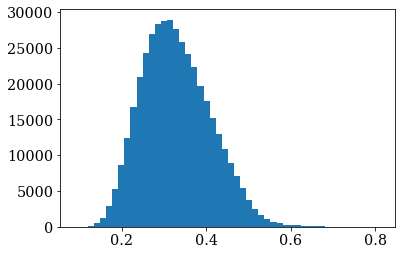

In [50]:
plt.hist(maxvals, bins = 50)
plt.show()

In [44]:
dondemas = np.where(maxvals > maxdata)

In [47]:
np.array(maxvals)[dondemas]

array([0.81094548, 0.77111325])

In [51]:
(500000/10.)*5.

250000.0

In [15]:
np.sqrt(np.std(mag))

0.2520657197680409

In [24]:
maxdata

0.7698648009572514